In [1]:
import sys
sys.path.append('..') 
import os

import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

## Data Loading

In [2]:
# # Save feature_engineered_df 
# feature_engineered_df.to_csv("data/feature_engineered_df.csv")
# # Load feature_engineered_df 
parse_dates = ["date"]
feature_engineered_df = pd.read_csv('data/feature_engineered_df.csv', index_col=[0], parse_dates=parse_dates)
feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 18 to 5912
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              4455 non-null   datetime64[ns]
 1   province                          4455 non-null   object        
 2   current_month_consumption         4455 non-null   float64       
 3   ARIMA_prediction                  4455 non-null   float64       
 4   last_year_same_month_consumption  4455 non-null   float64       
 5   last_year_total_consumption       4455 non-null   float64       
 6   rolling_mean_2                    4455 non-null   float64       
 7   rolling_mean_3                    4455 non-null   float64       
 8   rolling_mean_4                    4455 non-null   float64       
 9   rolling_mean_5                    4455 non-null   float64       
 10  rolling_mean_6                    4455 non-null

## Data Preperation

In [3]:
model_df = feature_engineered_df.sort_values(by=["date"]).reset_index(drop=True).copy()

In [4]:
from src.model_selection.data_preperation import DataPreperation as dp

# Train-Test split
X_train, y_train, X_test, y_test = dp.ts_train_test_split(
    data = model_df,
    index_column1="date",
    index_column2="province",
    lag=0, # 0 by default
    # n_months=55
    )

Maximum date at train is:  (Timestamp('2021-12-01 00:00:00'), 'ŞIRNAK')  Shape is:  (4374, 28)
Minimum date at train is:  (Timestamp('2017-07-01 00:00:00'), 'ADANA')  Shape is:  (4374, 28)
Maximum date at test is:  (Timestamp('2022-01-01 00:00:00'), 'ŞIRNAK')  Shape is:  (81, 28)
Minimum date at test is:  (Timestamp('2022-01-01 00:00:00'), 'ADANA')  Shape is:  (81, 28)


## Fine Tune

### Utils

#### Scoring

In [5]:
from typing import Any
import numpy as np
from sklearn.metrics import mean_squared_error 
def rmse(actual_value: Any, prediction: Any):
    return np.sqrt(((actual_value - prediction) ** 2)/2)

def ape(actual_value: Any, prediction: Any):
    return abs(actual_value-prediction)/actual_value*100
     
def prep_scoring_df(X_test: pd.DataFrame, y_test: pd.DataFrame, target_col: str="current_month_consumption", col_list: list=None)-> pd.DataFrame:
    scoring_df = X_test.copy()
    scoring_df["actual_value"] = y_test[target_col]
    scoring_df.reset_index(level="province",inplace=True)
    if not col_list:
        col_list = ["province", "actual_value"]
    scoring_df = scoring_df[col_list]
    return scoring_df

def scoring(scoring_df: pd.DataFrame, predictions: Any, model_name: str="XGB", target_value: str="actual_value")-> pd.DataFrame:
    if scoring_df.empty:
        print("Please run 'prep_scoring_df(X_test=X_test, y_test=y_test)' first in order to create scoring df")
        return
    else: 
        temp_df = scoring_df.copy()
    # Insert predictions
    temp_df[f"{model_name}_prediction"] = predictions
    # Add rmse
    temp_df[f"{model_name}_rmse"] = temp_df.apply(lambda row: rmse(row[target_value], row[f"{model_name}_prediction"]), axis=1)
    # Add percentage difference
    temp_df[f"{model_name}_absolute_percent_error"] = temp_df.apply(lambda row: ape(row[target_value], row[f"{model_name}_prediction"]), axis=1)
    
    print("Number of records greater than 20 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 20).sum())
    print("Number of records greater than 15 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 15).sum())
    print("Number of records greater than 10 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 10).sum())
    print("Number of records greater than 5 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 5).sum())
    return temp_df

In [6]:
def calc_grid_pairs(dict: dict()):
    prod = 1
    for key, value in dict.items():
        prod *= len(dict[key])
    print("Number of candidates are: ",prod)

### XGB

In [13]:
# Initialization parameters
init_params = {
    "objective": "reg:gamma"
}

grid_search_params = {
    # 'alpha': [0.0075, 0.0090], # Defaults to 0
    # 'colsample_bytree': [1.0], # Defaults to 1
    # 'lambda': [0.5], # Defaults to 1
    # 'learning_rate': [0.05], # Defaults to 0.3
    # 'max_depth': [9, 10], # Defaults to 6
    # 'min_child_weight': [3, 4], # Defaults to 1
    'n_estimators': [2500, 3000], 
    # 'subsample': [0.5], # Defaults to 1
}
calc_grid_pairs(grid_search_params)
# Use this in real production pipeline
# grid_search_params = {
#     'alpha': [0.0025, 0.005, 0.0075], # Defaults to 0
#     'lambda': [0.25, 0.5, 0.75], # Defaults to 1
#     'colsample_bytree': [1.0], # Defaults to 1
#     'learning_rate': [i for i in np.linspace(0.01,0.2, num=10)], # Defaults to 0.3
#     'max_depth': [6,7], # Defaults to 6
#     'min_child_weight': [2, 3, 4, 5], # Defaults to 1
#     'n_estimators': [1000, 1500, 2000], 
#     'subsample': [0.5], # Defaults to 1
# }
fit_params = {}

Number of candidates are:  2


In [8]:
print("# of columns are",len(model_df.columns))
model_df.columns

# of columns are 31


Index(['date', 'province', 'current_month_consumption', 'ARIMA_prediction',
       'last_year_same_month_consumption', 'last_year_total_consumption',
       'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4', 'rolling_mean_5',
       'rolling_mean_6', 'Lag1_monthly_share', 'Lag2_monthly_share',
       'Lag3_monthly_share', 'Lag4_monthly_share', 'Lag5_monthly_share',
       'Lag6_monthly_share', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6',
       'quarter', 'covid', 'school_holiday', 'population', 'trend',
       'yhat_lower', 'yhat_upper', 'yhat'],
      dtype='object')

In [10]:
from src.model_selection.modelling import xgb_simulator
for lag in range(1):
    print("Run for Lag=", lag)
    # Train test split
    # dp = DataPreperation(data=model_df.drop(columns=["yhat_lower","yhat_upper","trend","yhat"]))
    X_train, y_train, X_test, y_test = dp.ts_train_test_split(data=model_df, 
                                                              index_column1="date", 
                                                              index_column2="province", 
                                                              lag=lag
                                                              )
    # Initialize Simulator
    xgb = xgb_simulator(init_params=init_params, fit_params=fit_params, 
                        grid_search_params=grid_search_params, save=False)
    # Train the model
    xgb(X_train=X_train, y_train=y_train)
    # Set the best_model and best_parameter
    best_model = xgb.best_model
    best_params = xgb.best_params
    print(f"Best Parameters when lag = {lag}",best_params)
    # print("Best Score is: ",xgb.best_score_)
    # Predict test set
    predictons = best_model.predict(X_test)
    # Log results
    xgb_scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test,)
    xgb_scoring_df = scoring(predictions=predictons, scoring_df=xgb_scoring_df, model_name=f"Lag_{lag}_XGB")    


Run for Lag= 0
Maximum date at train is:  (Timestamp('2021-12-01 00:00:00'), 'ŞIRNAK')  Shape is:  (4374, 28)
Minimum date at train is:  (Timestamp('2017-07-01 00:00:00'), 'ADANA')  Shape is:  (4374, 28)
Maximum date at test is:  (Timestamp('2022-01-01 00:00:00'), 'ŞIRNAK')  Shape is:  (81, 28)
Minimum date at test is:  (Timestamp('2022-01-01 00:00:00'), 'ADANA')  Shape is:  (81, 28)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters when lag = 0 {'alpha': 0.0075, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 3000, 'subsample': 0.5}
Number of records greater than 20 percent error: 40
Number of records greater than 15 percent error: 51
Number of records greater than 10 percent error: 60
Number of records greater than 5 percent error: 74


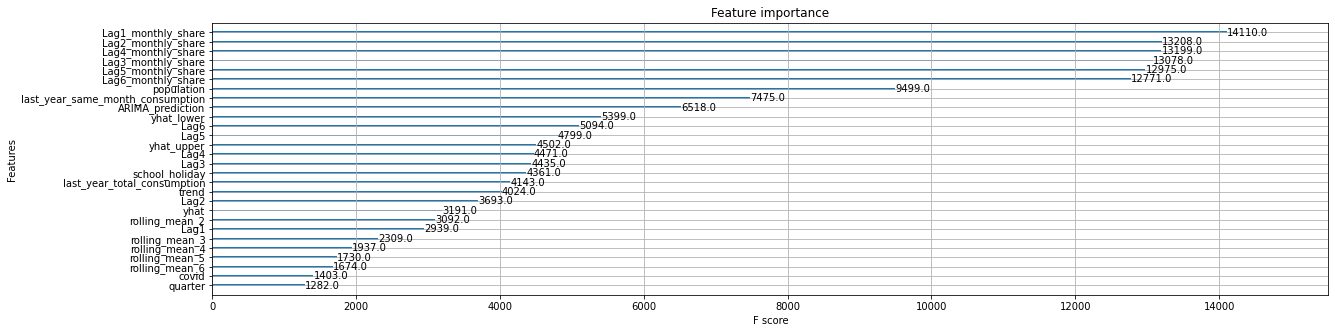

In [11]:
from xgboost import plot_importance
# for more information see: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance
from matplotlib import pyplot as plt
# Plot Feature Importances
plt.rcParams["figure.figsize"] = (20,5)
plot_importance(best_model, importance_type="weight")
plt.show()

In [ ]:
"""-----------------------------------------------------------------"""
# Run for Lag= 0
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# Best Parameters when lag = 0 {'alpha': 0.0075, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1250, 'subsample': 0.5}
# Number of records greater than 20 percent error: 2
# Number of records greater than 15 percent error: 3
# Number of records greater than 10 percent error: 6
# Number of records greater than 5 percent error: 20
# Run for Lag= 1
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# Best Parameters when lag = 1 {'alpha': 0.005, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1250, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 1
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 2
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Best Parameters when lag = 2 {'alpha': 0.005, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1250, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 0
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 3
"""-----------------------------------------------------------------"""
# Run for Lag= 0
# Fitting 5 folds for each of 360 candidates, totalling 1800 fits
# Best Parameters when lag = 0 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.75, 'learning_rate': 0.06444444444444444, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1500, 'subsample': 0.5}
# Number of records greater than 20 percent error: 2
# Number of records greater than 15 percent error: 3
# Number of records greater than 10 percent error: 4
# Number of records greater than 5 percent error: 24
# Run for Lag= 1
# Fitting 5 folds for each of 360 candidates, totalling 1800 fits
# Best Parameters when lag = 1 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.75, 'learning_rate': 0.07666666666666666, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1500, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 1
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 2
# Run for Lag= 2
# Fitting 5 folds for each of 360 candidates, totalling 1800 fits
# Best Parameters when lag = 2 {'alpha': 0.005, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.08888888888888888, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1500, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 0
# Number of records greater than 10 percent error: 0
# Number of records greater than 5 percent error: 7
"""-----------------------------------------------------------------"""
# Run for Lag= 0
# Fitting 5 folds for each of 16 candidates, totalling 80 fits
# Best Parameters when lag = 0 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.5}
# Number of records greater than 20 percent error: 2
# Number of records greater than 15 percent error: 3
# Number of records greater than 10 percent error: 7
# Number of records greater than 5 percent error: 17
# Run for Lag= 1
# Fitting 5 folds for each of 16 candidates, totalling 80 fits
# Best Parameters when lag = 1 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 2000, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 1
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 2
# Run for Lag= 2
# Fitting 5 folds for each of 16 candidates, totalling 80 fits
# Best Parameters when lag = 2 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 2000, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 0
# Number of records greater than 10 percent error: 2
# Number of records greater than 5 percent error: 3


'-----------------------------------------------------------------'

In [ ]:
xgb_scoring_df.head()

,province,actual_value,Lag_2_XGB_prediction,Lag_2_XGB_rmse,Lag_2_XGB_absolute_percent_error
date,,,,,
2021-11-01,ADANA,51866.171,52946.386719,763.827860,2.082698
2021-11-01,ADIYAMAN,14484.578,14374.851562,77.588308,0.757540
2021-11-01,AFYONKARAHİSAR,24347.612,25074.203125,513.777512,2.984240
2021-11-01,AKSARAY,15854.929,15710.470703,102.147441,0.911125
2021-11-01,AMASYA,14261.144,14388.799805,90.266285,0.895130


Shape of dataframe is :  (81, 5)


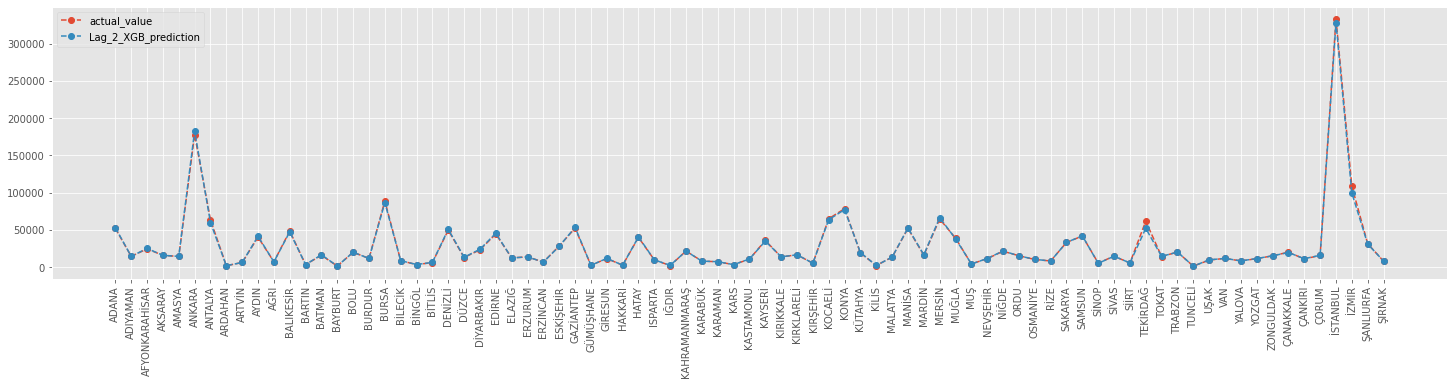

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(xgb_scoring_df, col_x="province", col_y1="actual_value", col_y2="Lag_2_XGB_prediction")

### LightGBM


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
init_params = {}
fit_params = {}
grid_search_params = {
    'task' : ['predict'],
    'boosting': ['gbdt' ],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [1500, 2000],
    'learning_rate':[0.05, 0.005],
    # 'num_leaves':[ 7, 15],
    'max_depth' :[ 10,15],
    'min_data_in_leaf':[15, 25],
    'feature_fraction': [ 0.6, 0.8],
    'bagging_fraction': [0.6, 0.8],
    'bagging_freq': [100, 200],
}

In [ ]:
# Single LightGBM Run
lgb_model = lgb.LGBMRegressor(**init_params)
# Initialize Data preperator
dp = DataPreperation(data=model_df.drop(columns=["yhat_lower","yhat_upper","trend","yhat"]))
# Train test split
X_train, y_train, X_test, y_test = dp.ts_train_test_split(index_column1="date" ,index_column2="province", lag=lag, n_months=55)
# Initialize lgb Regressor
lgb_model = lgb.LGBMRegressor(**init_params)
# Train the model
lgb_model.fit(X=X_train,y=y_train)
# Predict test set
predictons = lgb_model.predict(X_test)
# Log results
lgb_scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test,)
lgb_scoring_df = scoring(predictions=predictons, scoring_df=lgb_scoring_df, model_name=f"Lag_{lag}_LGB")    

Number of records greater than 20 percent error: 2
Number of records greater than 15 percent error: 3
Number of records greater than 10 percent error: 7
Number of records greater than 5 percent error: 16


In [ ]:
from src.model_selection.data_preperation import DataPreperation
for lag in range(3):
    print("Run for Lag=", lag)
    # Initialize Data preperator
    dp = DataPreperation(data=model_df)
    # dp = DataPreperation(data=model_df.drop(columns=["yhat_lower","yhat_upper","trend","ARIMA_prediction"]))
    # Train test split
    X_train, y_train, X_test, y_test = dp.ts_train_test_split(index_column1="date" ,index_column2="province", lag=lag, n_months=55)
    # Initialize lgb Regressor
    lgb_model = lgb.LGBMRegressor(**init_params)
    # Initialize Cross Validator
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=81)
    # Initialize Grid
    gs_lgb = GridSearchCV(estimator=lgb_model, 
                        param_grid=grid_search_params, 
                        n_jobs=-1, cv= tscv,
                        scoring="neg_mean_absolute_percentage_error", 
                        )
    # Train the model
    gs_lgb.fit(X_train,y_train,**fit_params)
    # Set the best_model and best_parameter
    best_model = gs_lgb.best_estimator_
    best_params = gs_lgb.best_params_
    print(f"Best Parameters when lag = {lag}",best_params)
    # print("Best Score is: ",xgb.best_score_)
    # Predict test set
    predictons = best_model.predict(X_test)
    # Log results
    lgb_scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test,)
    lgb_scoring_df = scoring(predictions=predictons, scoring_df=lgb_scoring_df, model_name=f"Lag_{lag}_LGB")    

Run for Lag= 0


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
Best Parameters when lag = 0 {'bagging_fraction': 0.8, 'bagging_freq': 100, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.05, 'max_depth': 15, 'min_data_in_leaf': 25, 'num_iterations': 2000, 'objective': 'root_mean_squared_error', 'task': 'predict'}
Number of records greater than 20 percent error: 4
Number of records greater than 15 percent error: 6
Number of records greater than 10 percent error

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=200, subsample_freq=0 will be ignored. Current value: bagging_freq=200
Best Parameters when lag = 1 {'bagging_fraction': 0.8, 'bagging_freq': 200, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.05, 'max_depth': 15, 'min_data_in_leaf': 15, 'num_iterations': 2000, 'objective': 'root_mean_squared_error', 'task': 'predict'}
Number of records greater than 20 percent error: 0
Number of records greater than 15 percent error: 1
Number of records greater than 10 percent error

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
Best Parameters when lag = 2 {'bagging_fraction': 0.8, 'bagging_freq': 100, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'learning_rate': 0.05, 'max_depth': 15, 'min_data_in_leaf': 15, 'num_iterations': 2000, 'objective': 'root_mean_squared_error', 'task': 'predict'}
Number of records greater than 20 percent error: 2
Number of records greater than 15 percent error: 4
Number of records greater than 10 percent error

In [ ]:
lgb_scoring_df.head()

,province,actual_value,Lag_2_LGB_prediction,Lag_2_LGB_rmse,Lag_2_LGB_absolute_percent_error
date,,,,,
2021-11-01,ADANA,51866.171,52313.768202,316.499017,0.862985
2021-11-01,ADIYAMAN,14484.578,14081.621761,284.933089,2.781967
2021-11-01,AFYONKARAHİSAR,24347.612,24685.251081,238.746884,1.386744
2021-11-01,AKSARAY,15854.929,16204.403776,247.115984,2.204203
2021-11-01,AMASYA,14261.144,14116.940655,101.967163,1.011163


Shape of dataframe is :  (81, 5)


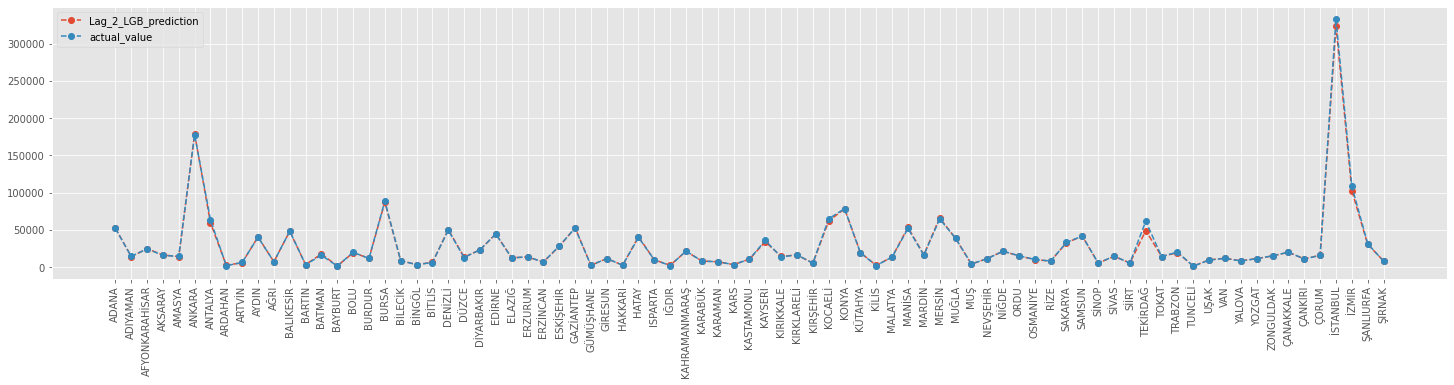

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(lgb_scoring_df, col_x="province", col_y1="Lag_2_LGB_prediction", col_y2="actual_value")

### CatBoost

In [ ]:
import catboost as cbt

In [ ]:
init_params = {}
fit_params = {}
grid_search_params = {'depth'         : [6,10,14],
                'learning_rate' : [0.01,0.03,0.05],
                'iterations'    : [10,50,100]
                }

In [ ]:
# Single Catboost Run
# Initialize Data preperator
dp = DataPreperation(data=model_df)
# Train test split
X_train, y_train, X_test, y_test = dp.ts_train_test_split(index_column1="date" ,index_column2="province", lag=lag, n_months=55)
# Initialize cbt Regressor
cbt_model = cbt.CatBoostRegressor(**init_params)
# Train the model
cbt_model.fit(X=X_train,y=y_train)
# Predict test set
predictons = cbt_model.predict(X_test)
# Log results
cbt_scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test,)
cbt_scoring_df = scoring(predictions=predictons, scoring_df=xgb_scoring_df, model_name=f"Lag_{lag}_CBT")    

Learning rate set to 0.051844
0:	learn: 39529.4529515	total: 142ms	remaining: 2m 22s
1:	learn: 37756.7973088	total: 145ms	remaining: 1m 12s
2:	learn: 36017.8899817	total: 148ms	remaining: 49s
3:	learn: 34338.6781180	total: 150ms	remaining: 37.3s
4:	learn: 32731.7964038	total: 153ms	remaining: 30.4s
5:	learn: 31293.2605667	total: 155ms	remaining: 25.7s
6:	learn: 29839.3301419	total: 158ms	remaining: 22.4s
7:	learn: 28451.3488876	total: 161ms	remaining: 19.9s
8:	learn: 27149.8525845	total: 163ms	remaining: 17.9s
9:	learn: 25973.2784358	total: 165ms	remaining: 16.4s
10:	learn: 24780.2673928	total: 168ms	remaining: 15.1s
11:	learn: 23687.0327562	total: 171ms	remaining: 14.1s
12:	learn: 22681.5321664	total: 174ms	remaining: 13.2s
13:	learn: 21649.7906218	total: 176ms	remaining: 12.4s
14:	learn: 20719.2218149	total: 179ms	remaining: 11.8s
15:	learn: 19818.3900007	total: 181ms	remaining: 11.2s
16:	learn: 18933.5442208	total: 184ms	remaining: 10.6s
17:	learn: 18108.6198436	total: 187ms	remaini

In [ ]:
for lag in range(3):
    print("Run for Lag=", lag)
    # Initialize Data preperator
    dp = DataPreperation(data=model_df)
    # dp = DataPreperation(data=model_df.drop(columns=["yhat_lower","yhat_upper","trend","ARIMA_prediction"]))
    # Train test split
    X_train, y_train, X_test, y_test = dp.ts_train_test_split(index_column1="date" ,index_column2="province", lag=lag, n_months=55)
    # Initialize cbt Regressor
    cbt_model = cbt.CatBoostRegressor(**init_params)
    # Initialize Cross Validator
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=81)
    # Initialize Grid
    gs_lgb = GridSearchCV(estimator=cbt_model, 
                        param_grid=grid_search_params, 
                        n_jobs=-1, cv= tscv,
                        scoring="neg_mean_absolute_percentage_error", 
                        )
    # Train the model
    gs_lgb.fit(X_train,y_train,**fit_params)
    # Set the best_model and best_parameter
    best_model = gs_lgb.best_estimator_
    best_params = gs_lgb.best_params_
    print(f"Best Parameters when lag = {lag}",best_params)
    print("Best Score is: ",gs_lgb.best_score_)
    # Predict test set
    predictons = best_model.predict(X_test)
    # Log results
    cbt_scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test,)
    cbt_scoring_df = scoring(predictions=predictons, scoring_df=cbt_scoring_df, model_name=f"Lag_{lag}_CBT")

Run for Lag= 0
0:	learn: 39729.9584624	total: 34.7ms	remaining: 3.44s
1:	learn: 37933.6287742	total: 72ms	remaining: 3.53s
2:	learn: 36277.0106378	total: 109ms	remaining: 3.51s
3:	learn: 34855.8486129	total: 145ms	remaining: 3.48s
4:	learn: 33388.4138569	total: 183ms	remaining: 3.48s
5:	learn: 31913.2490873	total: 216ms	remaining: 3.39s
6:	learn: 30583.5273774	total: 255ms	remaining: 3.39s
7:	learn: 29231.5360378	total: 291ms	remaining: 3.34s
8:	learn: 27938.9178968	total: 327ms	remaining: 3.31s
9:	learn: 26805.2137393	total: 363ms	remaining: 3.27s
10:	learn: 25590.8289560	total: 397ms	remaining: 3.21s
11:	learn: 24499.3733675	total: 433ms	remaining: 3.17s
12:	learn: 23553.0362348	total: 468ms	remaining: 3.13s
13:	learn: 22506.5443056	total: 503ms	remaining: 3.09s
14:	learn: 21506.4411667	total: 538ms	remaining: 3.05s
15:	learn: 20584.6738246	total: 570ms	remaining: 2.99s
16:	learn: 19679.8265868	total: 601ms	remaining: 2.93s
17:	learn: 18847.5090282	total: 632ms	remaining: 2.88s
18:	l

In [ ]:
cbt_scoring_df.head()

,province,actual_value,Lag_2_CBT_prediction,Lag_2_CBT_rmse,Lag_2_CBT_absolute_percent_error
date,,,,,
2021-11-01,ADANA,51866.171,53589.954585,1218.899062,3.323522
2021-11-01,ADIYAMAN,14484.578,14253.507157,163.391760,1.595289
2021-11-01,AFYONKARAHİSAR,24347.612,24775.798255,302.773405,1.758638
2021-11-01,AKSARAY,15854.929,16037.141871,128.843957,1.149251
2021-11-01,AMASYA,14261.144,15093.380466,588.480048,5.835692


Shape of dataframe is :  (81, 5)


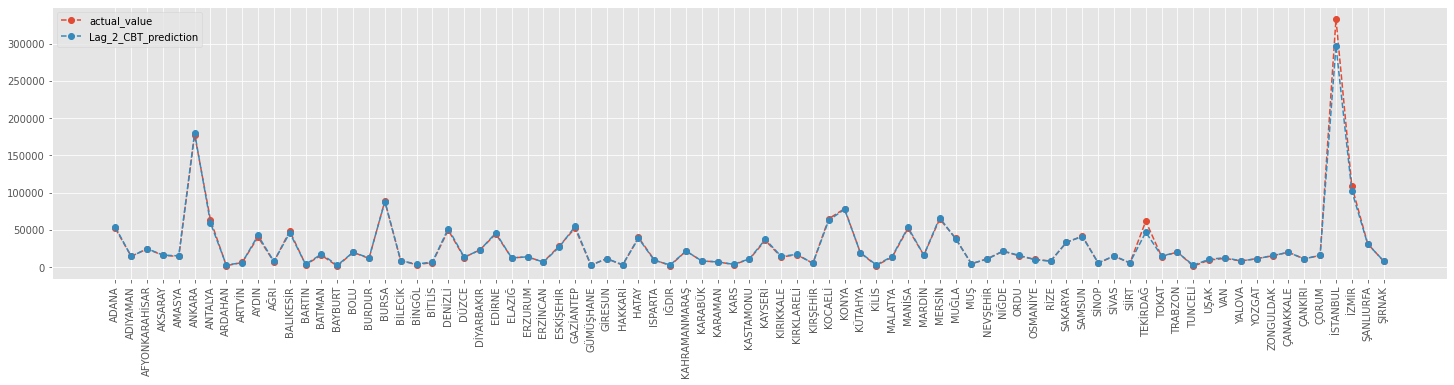

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(cbt_scoring_df, col_x="province", col_y1="actual_value", col_y2="Lag_2_CBT_prediction")

### PROPHET

In [ ]:
# aware of statsmodel and prophet packages differences between python 3.8 and 3.10

In [ ]:
# Module Simulation
# # Load feature_engineered_df 
parse_dates = ["date"]
preprocessed_df = pd.read_csv('data/preprocessed_df.csv', index_col=[0], parse_dates=parse_dates)
preprocessed_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5913 entries, 0 to 5912
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       5913 non-null   datetime64[ns]
 1   province                   5913 non-null   object        
 2   current_month_consumption  5913 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 184.8+ KB


In [ ]:
col_rename_dict = {"date":"ds","current_month_consumption":"y"}
preprocessed_df.rename(columns=col_rename_dict, inplace=True)

In [ ]:
col_rename_dict = {v: k for k, v in col_rename_dict.items()}


In [ ]:
col_rename_dict

{'ds': 'date', 'y': 'current_month_consumption'}

In [ ]:
from prophet import Prophet
def train_(model_df: pd.DataFrame):
    m = Prophet()
    m.fit(model_df)
    return m   
col_list = ['ds', 'province', 'trend', 'yhat_lower', 'yhat_upper', 'yhat']
periods = 0
temp_df = preprocessed_df.copy()
# Initialize columns to be passed
empty_df = pd.DataFrame()
for prov in temp_df.province.unique():
    temp_df_ = temp_df.query(f"province == '{prov}'").copy()
    # Train the Prophet model
    m = train_(model_df=temp_df_)
    # Create Future Dataframe
    future = m.make_future_dataframe(periods=periods,freq="MS")
    # Predict Future
    forecast = m.predict(future)
    # Insert province into forecasts
    forecast["province"] = prov
    # Concat results
    empty_df = pd.concat([empty_df,forecast[col_list]], ignore_index=True)
temp_df = temp_df.merge(empty_df, on=["ds","province"], how="left")
col_rename_dict = {v: k for k, v in col_rename_dict.items()}
temp_df.rename(columns=col_rename_dict, inplace=True)


20:35:44 - cmdstanpy - INFO - Chain [1] start processing
20:35:45 - cmdstanpy - INFO - Chain [1] done processing
20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:46 - cmdstanpy - INFO - Chain [1] done processing
20:35:46 - cmdstanpy - INFO - Chain [1] start processing
20:35:46 - cmdstanpy - INFO - Chain [1] done processing
20:35:47 - cmdstanpy - INFO - Chain [1] start processing
20:35:47 - cmdstanpy - INFO - Chain [1] done processing
20:35:48 - cmdstanpy - INFO - Chain [1] start processing
20:35:48 - cmdstanpy - INFO - Chain [1] done processing
20:35:48 - cmdstanpy - INFO - Chain [1] start processing
20:35:49 - cmdstanpy - INFO - Chain [1] done processing
20:35:49 - cmdstanpy - INFO - Chain [1] start processing
20:35:49 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:51 - cmdstanpy - INFO - Chain [1] start processing
20:35:51 - cmdstanpy - INFO - Chain [1]

In [ ]:
empty_df

,ds,province,trend,yhat_lower,yhat_upper,yhat
0,2016-01-01,ÇANKIRI,4236.812015,-814.273582,5414.634960,2197.996141
1,2016-02-01,ÇANKIRI,4357.609142,-1511.637735,4722.250446,1656.578121
2,2016-03-01,ÇANKIRI,4470.612907,535.303724,6777.336370,3608.426184
3,2016-04-01,ÇANKIRI,4591.410034,681.746581,6746.269896,3876.936577
4,2016-05-01,ÇANKIRI,4708.310480,668.959824,6690.474058,3631.586214
...,...,...,...,...,...,...
5908,2021-09-01,KONYA,73703.769376,73316.664982,88916.240832,81045.893929
5909,2021-10-01,KONYA,73836.279542,76726.841166,93234.186647,84922.589738
5910,2021-11-01,KONYA,73973.206714,70485.741482,86872.918105,78638.779398
5911,2021-12-01,KONYA,74105.716880,57629.746349,73379.733321,65707.680689


In [ ]:
temp_df = temp_df.merge(empty_df, on=["ds","province"], how="left")

In [ ]:
temp_df.head(9)

,ds,province,y,trend_x,yhat_lower_x,yhat_upper_x,yhat_x,trend_y,yhat_lower_y,yhat_upper_y,yhat_y
0,2016-01-01,ÇANKIRI,3082.148,4236.812015,-814.273582,5414.634960,2197.996141,4236.812015,-814.273582,5414.634960,2197.996141
1,2016-01-01,ÇANAKKALE,10286.528,14800.123956,9505.476862,12334.625484,10883.253982,14800.123956,9505.476862,12334.625484,10883.253982
2,2016-01-01,ÇORUM,7218.320,12501.911626,5521.065922,8996.651752,7252.422204,12501.911626,5521.065922,8996.651752,7252.422204
3,2016-01-01,DENİZLİ,31509.926,33841.749021,21279.264741,32891.767496,27352.170002,33841.749021,21279.264741,32891.767496,27352.170002
4,2016-01-01,DİYARBAKIR,9068.408,14658.566393,8696.003488,12565.846188,10563.938366,14658.566393,8696.003488,12565.846188,10563.938366
5,2016-01-01,DÜZCE,9779.135,11517.870606,6930.117591,11028.684741,9004.689592,11517.870606,6930.117591,11028.684741,9004.689592
6,2016-01-01,EDİRNE,18907.808,17633.050030,8744.113740,20247.246272,14378.479367,17633.050030,8744.113740,20247.246272,14378.479367
7,2016-01-01,ELAZIĞ,7347.935,13517.910778,7249.543473,10904.695984,9111.078450,13517.910778,7249.543473,10904.695984,9111.078450
8,2016-01-01,ERZİNCAN,3115.698,4628.057618,1975.420652,3101.549811,2530.229231,4628.057618,1975.420652,3101.549811,2530.229231


In [ ]:
list(temp_df.columns).remove("y")

In [ ]:
prov= "ANKARA"
temp_df_ = temp_df.query(f"province == '{prov}'").copy()
m = train_(model_df=temp_df_)
future = m.make_future_dataframe(periods=periods,freq="MS")
forecast = m.predict(future)
forecast["province"] = prov
temp_df = pd.merge(temp_df, forecast, on=["ds","province"], how="left")

20:36:44 - cmdstanpy - INFO - Chain [1] start processing
20:36:44 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
"""---------------------------------------"""

'---------------------------------------'

In [ ]:
# Prepare df for prophet
prop_df = feature_engineered_df.query("province == 'ADANA'").copy()
prop_df.rename(columns={"date":"ds","current_month_consumption":"y"},inplace=True)
prop_df.head()

,ds,province,y,ARIMA_prediction,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,...,previous_2_month_consumption,previous_3_month_consumption,quarter,covid,school_holiday,population,trend,yhat_lower,yhat_upper,yhat
15,2017-04-01,ADANA,41359.841,40690.801551,45689.131,550052.298,0.075193,0.074600,0.068349,0.070209,...,37768.097,38776.434,2,0,10,2216475.0,46101.463604,37564.971923,48821.801546,42954.267992
16,2017-05-01,ADANA,44928.990,41296.608999,48584.283,545723.008,0.082329,0.075193,0.074600,0.068349,...,40979.795,37768.097,2,0,10,2216475.0,46169.349492,39872.223664,51477.132241,45741.344966
17,2017-06-01,ADANA,51147.202,44585.687793,49633.935,542067.715,0.094356,0.082329,0.075193,0.074600,...,41359.841,40979.795,2,0,21,2216475.0,46239.498245,42995.986653,54274.261714,48676.467322
18,2017-07-01,ADANA,52226.264,50527.062674,45859.035,543580.982,0.096078,0.094356,0.082329,0.075193,...,44928.990,41359.841,3,0,31,2216475.0,46307.384134,44001.004413,56000.109962,49834.030167
19,2017-08-01,ADANA,54431.449,52065.669733,51812.765,549948.211,0.098976,0.096078,0.094356,0.082329,...,51147.202,44928.990,3,0,31,2216475.0,46377.532885,46977.928736,58208.170160,52579.093180


In [ ]:
from prophet import Prophet
# Initialize prophet object
m = Prophet()
m.fit(prop_df)
future = m.make_future_dataframe(periods=0,freq="MS")
raw_forecast = m.predict(future)
raw_forecast.tail(6)

20:36:45 - cmdstanpy - INFO - Chain [1] start processing
20:36:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
52,2021-08-01,52890.762089,53504.658124,64884.242718,52890.762089,52890.762089,6247.635045,6247.635045,6247.635045,6247.635045,6247.635045,6247.635045,0.0,0.0,0.0,59138.397134
53,2021-09-01,53119.007168,52164.491710,63676.304804,53119.007168,53119.007168,4856.750155,4856.750155,4856.750155,4856.750155,4856.750155,4856.750155,0.0,0.0,0.0,57975.757323
54,2021-10-01,53339.889501,51865.378455,63061.765792,53339.889501,53339.889501,4286.664733,4286.664733,4286.664733,4286.664733,4286.664733,4286.664733,0.0,0.0,0.0,57626.554234
55,2021-11-01,53568.134580,48878.985099,60677.055455,53568.134580,53568.134580,1091.254529,1091.254529,1091.254529,1091.254529,1091.254529,1091.254529,0.0,0.0,0.0,54659.389109
56,2021-12-01,53789.016914,47055.462438,57855.610818,53789.016914,53789.016914,-1173.827470,-1173.827470,-1173.827470,-1173.827470,-1173.827470,-1173.827470,0.0,0.0,0.0,52615.189443
57,2022-01-01,54017.261992,40783.070344,52574.589284,54017.261992,54017.261992,-7211.006796,-7211.006796,-7211.006796,-7211.006796,-7211.006796,-7211.006796,0.0,0.0,0.0,46806.255196


In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Generate all combinations of parameters

mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prop_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
best_params = all_params[np.argmin(mapes)]
print(tuning_results)
print(best_params)

20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:37:06 - cmdstanpy - INFO - Chain [1] start processing
20:37:06 - cmdstanpy - INFO - Chain [1] done processing
20:37:19 - cmdstanpy - INFO - Chain [1] start processing
20:37:19 - cmdstanpy - INFO - Chain [1] done processing
20:37:32 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:46 - cmdstanpy - INFO - Chain [1] start processing
20:37:47 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing
20:38:11 - cmdstanpy - INFO - Chain [1] done processing
20:38:34 - cmdstanpy - INFO - Chain [1] start processing
20:38:34 - cmdstanpy - INFO - Chain [1] done processing
20:38:55 - cmdstanpy - INFO - Chain [1] start processing
20:38:56 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  0.113797
1                     0.001                     0.10  0.124242
2                     0.001                     1.00  0.171355
3                     0.001                    10.00  0.262315
4                     0.010                     0.01  0.113467
5                     0.010                     0.10  0.125502
6                     0.010                     1.00  0.166452
7                     0.010                    10.00  0.270295
8                     0.100                     0.01  0.114083
9                     0.100                     0.10  0.103933
10                    0.100                     1.00  0.133604
11                    0.100                    10.00  0.282888
12                    0.500                     0.01  0.112645
13                    0.500                     0.10  0.099982
14                    0.500                     1.00  0

In [ ]:
best_params

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}

In [ ]:
from prophet import Prophet
# Initialize prophet object
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# m = Prophet(changepoint_prior_scale=0.5,seasonality_prior_scale=1.0).fit(prop_df)
m = Prophet(**best_params)
m.add_country_holidays(country_name='TR')
m.fit(prop_df)
future = m.make_future_dataframe(periods=1,freq="MS")
forecast_only_gs = m.predict(future)
forecast_only_gs[["ds","yhat","yhat_lower","yhat_upper"]].tail(6)


20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
53,2021-09-01,56972.411624,53452.626766,60588.434166
54,2021-10-01,55864.910816,52482.442335,59511.382231
55,2021-11-01,51863.873482,48217.169876,55443.052116
56,2021-12-01,49390.573161,45928.738326,52969.589393
57,2022-01-01,43283.498114,39814.550902,46995.158743
58,2022-02-01,42744.726200,39306.071513,46254.465609


Text(0.5, 1.0, 'Lockdowns as one-off holidays')

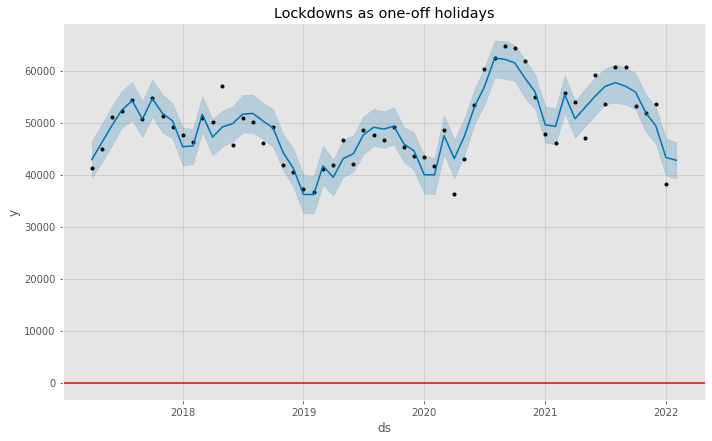

In [ ]:
import matplotlib.pyplot as plt
m.plot(forecast_only_gs)
# plt.plot(prop_df.ds,prop_df.y)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays')

In [ ]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

m2 = Prophet(**best_params,holidays=lockdowns)
m2 = m2.fit(prop_df)
future2 = m2.make_future_dataframe(periods=1,freq="MS")
forecast_gs_hols = m2.predict(future2)

20:46:05 - cmdstanpy - INFO - Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
forecast_gs_hols[["ds","yhat","yhat_lower","yhat_upper",]].tail(6)

,ds,yhat,yhat_lower,yhat_upper
53,2021-09-01,55362.386784,52484.875415,58067.861516
54,2021-10-01,55079.863611,52216.243584,57960.935613
55,2021-11-01,51830.748460,49217.542562,54727.543452
56,2021-12-01,49067.897349,46135.436253,51899.034488
57,2022-01-01,42765.959378,39888.078586,45620.916819
58,2022-02-01,41998.493586,39292.389723,44915.103625


Text(0.5, 1.0, 'Lockdowns as one-off holidays')

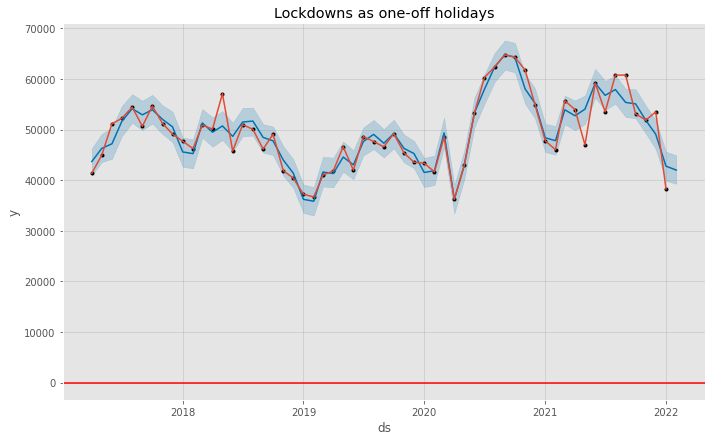

In [ ]:
import matplotlib.pyplot as plt
m2.plot(forecast_gs_hols)
plt.plot(prop_df.ds,prop_df.y)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays')

In [ ]:
scoring_df = prop_df[["ds","y"]].copy()
scoring_df = scoring(scoring_df=scoring_df,predictions=raw_forecast.yhat_upper,model_name="raw_forecast", target_value="y")
scoring_df = scoring(scoring_df=scoring_df,predictions=forecast_only_gs.yhat_upper,model_name="forecast_only_gs", target_value="y")
scoring_df = scoring(scoring_df=scoring_df,predictions=forecast_gs_hols.yhat_upper,model_name="forecast_gs_hols", target_value="y")
scoring_df.head()

Number of records greater than 20 percent error: 19
Number of records greater than 15 percent error: 24
Number of records greater than 10 percent error: 31
Number of records greater than 5 percent error: 34
Number of records greater than 20 percent error: 22
Number of records greater than 15 percent error: 24
Number of records greater than 10 percent error: 31
Number of records greater than 5 percent error: 36
Number of records greater than 20 percent error: 21
Number of records greater than 15 percent error: 22
Number of records greater than 10 percent error: 26
Number of records greater than 5 percent error: 34


,ds,y,raw_forecast_prediction,raw_forecast_rmse,raw_forecast_absolute_percent_error,forecast_only_gs_prediction,forecast_only_gs_rmse,forecast_only_gs_absolute_percent_error,forecast_gs_hols_prediction,forecast_gs_hols_rmse,forecast_gs_hols_absolute_percent_error
15,2017-04-01,41359.841,57399.555241,11341.790708,38.780890,55306.905368,9862.063792,33.721272,54274.163187,9131.804793,31.224303
16,2017-05-01,44928.990,58823.690736,9825.037113,30.925914,55339.630435,7361.434448,23.171321,54340.426103,6654.890289,20.947357
17,2017-06-01,51147.202,57326.826365,4369.654294,12.082038,53791.009850,1869.454459,5.169018,51059.104536,62.294314,0.172243
18,2017-07-01,52226.264,58672.229336,4557.985800,12.342383,52563.875687,238.727513,0.646440,50611.410304,1141.873999,3.092034
19,2017-08-01,54431.449,54214.967058,153.075850,0.397715,47705.638269,4755.866377,12.356479,46711.396386,5458.901555,14.183074


Shape of dataframe is :  (58, 11)


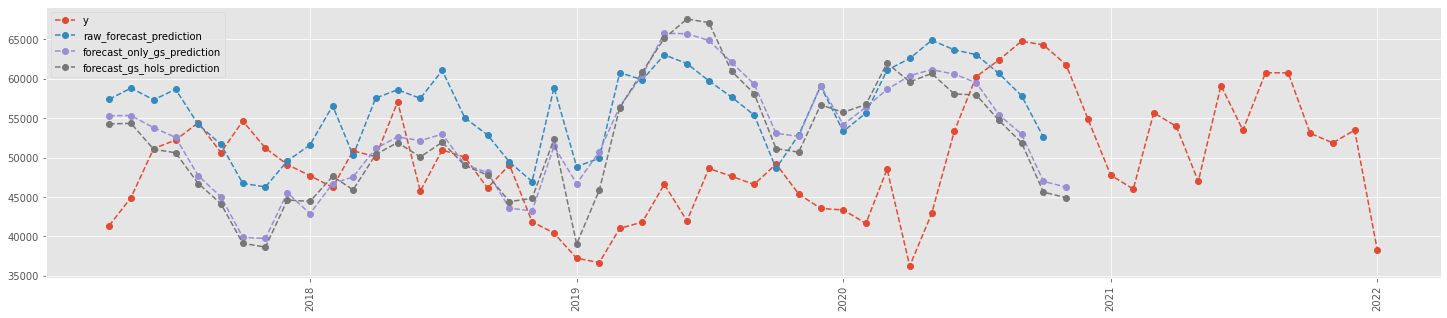

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(scoring_df, col_x="ds", col_y1="y", col_y2="raw_forecast_prediction", col_y3="forecast_only_gs_prediction", col_y4="forecast_gs_hols_prediction")

In [ ]:
# prop_df -> y
# raw_forecast -> y
# forecast_only_gs -> y
# forecast_gs_hols -> y